In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, RepeatVector, Input, Concatenate, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
# Hyperparameters
seq_length = 100  # Length of the time series sequences
n_features = 1   # Number of features in the time series
#epochs = 1000   # Number of epochs to train
batch_size = 32  # Batch size
learning_rate = 0.0002  # Initial learning rate
n_samples=1000
forcast_horizen=10 # Length of the forcasting period

In [4]:
# Generate sine wave data
def generate_sine_wave(seq_length, n_samples):
    x = np.linspace(0, np.pi * 4, seq_length)
    data = np.array([np.sin(x + i) for i in np.linspace(0, 2*np.pi, n_samples)])
    #print(data.shape) 
    data = data.reshape((n_samples, seq_length, n_features))
    print(data.shape) 
    x=data[:-50]
    y=data[50:]
    print(x.shape,y.shape)
    return x,y

def generate_sine_wave_with_linear(seq_length, n_samples,a=1,b=0):
    # Time vector
    samples_per_second=int(n_samples/seq_length)
    
    t = np.linspace(0, seq_length, n_samples)  #  totallength seconds sampled at n_samples points

    # Main long-period sinusoid (e.g., period of 5 seconds)
    long_period_sinusoid = np.sin(2 * np.pi * t / 5)

    # High-frequency fluctuations (e.g., period of 1 second)
    high_freq_fluctuation_1 = 0.2 * np.sin(2 * np.pi * t / 1)  # 20% amplitude of the main signal
    high_freq_fluctuation_2 = 0.1 * np.sin(2 * np.pi * t / 0.5)  # 10% amplitude of the main signal

    # Combined signal
    #combined_signal = long_period_sinusoid + high_freq_fluctuation_1 + high_freq_fluctuation_2
    combined_signal = long_period_sinusoid 

    # Low gradient linear increment
    linear_increment = 0 * t  # Small slope (0.05) linear increment

    # Signal with linear increment
    #final_signal = combined_signal + linear_increment
    final_signal = combined_signal 
    print(final_signal.shape)
    forcast_horizen_index=int(forcast_horizen*samples_per_second)
    x=final_signal[0:-forcast_horizen_index]
    y=final_signal[forcast_horizen_index:]
    print(x.shape,y.shape)
    x = x.reshape((-1, seq_length, n_features))
    y = y.reshape((-1, seq_length, n_features))
    print(x.shape,y.shape)
    
    return x,y

In [5]:
# Generate sine wave data
x,y = generate_sine_wave(seq_length, n_samples)
# Sine Wave with linear component (ax+b)

#x,y =generate_sine_wave_with_linear(seq_length, n_samples,a=1,b=1)


(1000, 100, 1)
(950, 100, 1) (950, 100, 1)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,shuffle=False)
x_train.shape
  
    

(760, 100, 1)

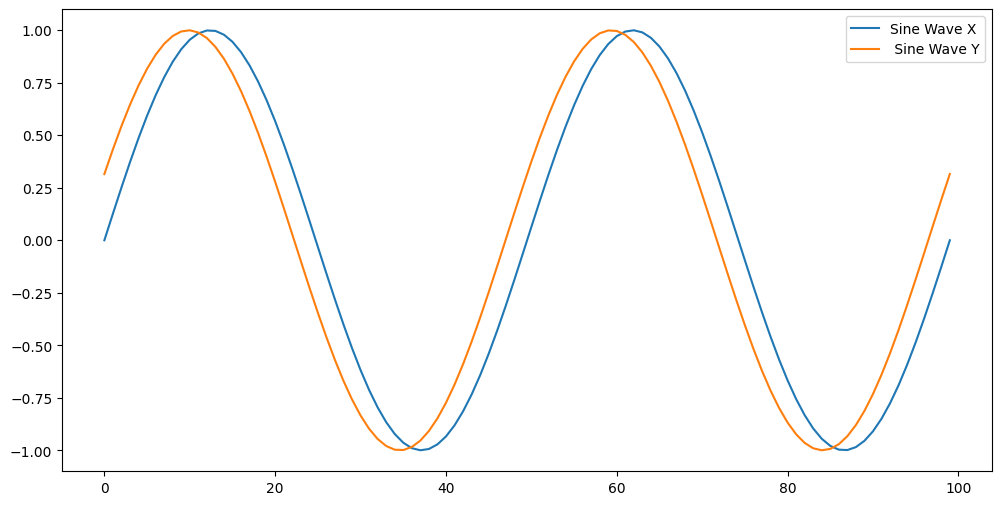

In [22]:
# Plot real vs. synthetic sine wave
plt.figure(figsize=(12, 6))
plt.plot(x_train[0].reshape(-1), label='Sine Wave X')
plt.plot(y_train[1].reshape(-1), label=' Sine Wave Y')
plt.legend()
plt.show()

In [9]:
# Generator model
def build_generator(seq_length, n_features):
    #noise_input = Input(shape=(seq_length, n_features))
    context_input = Input(shape=(seq_length,n_features))
    
    #merged_input = Concatenate()([noise_input, context_input])
    
    lstm1 = LSTM(200, activation='tanh', return_sequences=True)(context_input)
    lstm2 = LSTM(100, activation='tanh')(lstm1)
    repeat = RepeatVector(seq_length)(lstm2)
    lstm3 = LSTM(100, activation='tanh', return_sequences=True)(repeat)
    dropout = Dropout(0.4)(lstm3)
    output = TimeDistributed(Dense(n_features))(dropout)
    
    model = Model(inputs=[context_input], outputs=output)
    return model

In [10]:
generator = build_generator(seq_length, n_features)

In [11]:
generator.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 100, 200)          161600    
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 repeat_vector (RepeatVector  (None, 100, 100)         0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 100, 100)          80400     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                             

In [12]:
history = generator.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
24/24 [==============================] - 7s 34ms/step - loss: 0.4528 - accuracy: 0.0000e+00
Epoch 2/5
24/24 [==============================] - 0s 19ms/step - loss: 0.1463 - accuracy: 7.8947e-05
Epoch 3/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0363 - accuracy: 9.2105e-05
Epoch 4/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0237 - accuracy: 9.2105e-05
Epoch 5/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0194 - accuracy: 9.2105e-05


In [13]:
generated_data = generator.predict(x_test)

6/6 [==============================] - 1s 27ms/step


In [14]:
generated_data.shape

(190, 100, 1)

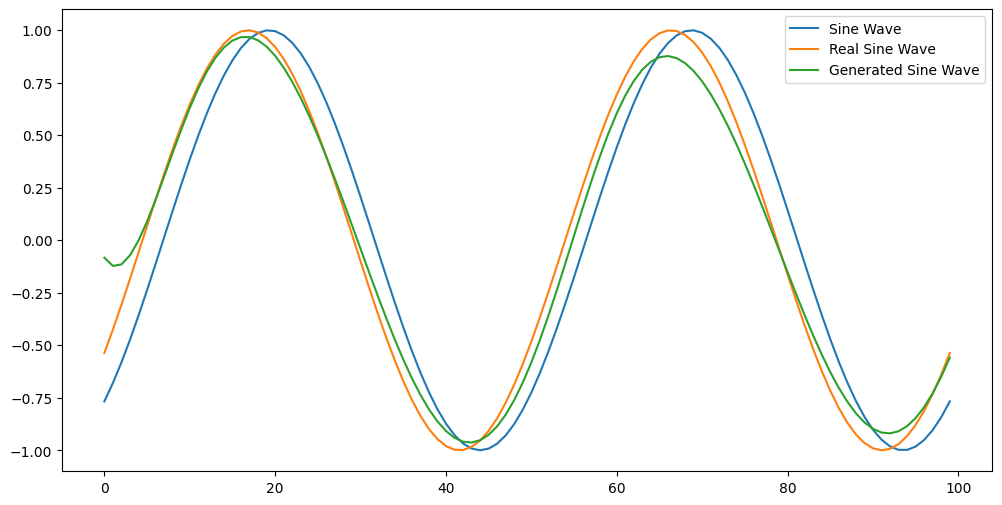

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(x_test[100].reshape(-1), label='Sine Wave')
plt.plot(y_test[99].reshape(-1), label='Real Sine Wave')
plt.plot(generated_data[100].reshape(-1), label='Generated Sine Wave')
plt.legend()
plt.show()

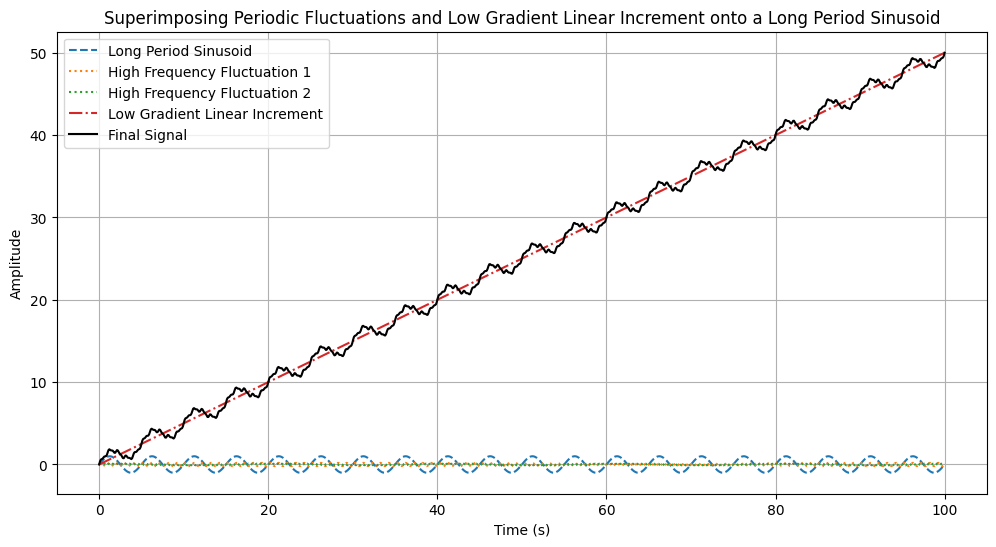

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Time vector
t = np.linspace(0, 100, 1000)  # 10 seconds sampled at 1000 points

# Main long-period sinusoid (e.g., period of 5 seconds)
long_period_sinusoid = np.sin(2 * np.pi * t / 5)

# High-frequency fluctuations (e.g., period of 1 second)
high_freq_fluctuation_1 = 0.2 * np.sin(2 * np.pi * t / 1)  # 20% amplitude of the main signal
high_freq_fluctuation_2 = 0.1 * np.sin(2 * np.pi * t / 0.5)  # 10% amplitude of the main signal

# Combined signal
combined_signal = long_period_sinusoid + high_freq_fluctuation_1 + high_freq_fluctuation_2

# Low gradient linear increment
linear_increment = 0.5 * t  # Small slope (0.05) linear increment

# Signal with linear increment
final_signal = combined_signal + linear_increment

# Plot the signals
plt.figure(figsize=(12, 6))
plt.plot(t, long_period_sinusoid, label='Long Period Sinusoid', linestyle='dashed')
plt.plot(t, high_freq_fluctuation_1, label='High Frequency Fluctuation 1', linestyle='dotted')
plt.plot(t, high_freq_fluctuation_2, label='High Frequency Fluctuation 2', linestyle='dotted')
plt.plot(t, linear_increment, label='Low Gradient Linear Increment', linestyle='dashdot')
plt.plot(t, final_signal, label='Final Signal', color='black')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Superimposing Periodic Fluctuations and Low Gradient Linear Increment onto a Long Period Sinusoid')
plt.grid(True)
plt.show()
